### パッケージのインポート

In [1]:
import os
import random
from datetime import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
# from swan import pycwt

### データの確認

In [2]:
# ディレクトリ下に存在するファイル名の取得
def get_file_data(dir_path) -> list:
    filenames = sorted(os.listdir(dir_path))
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
    return filenames


# 欠損値数と最大値をとる時刻の確認
def null_max_cnt(filename_path, df_list):
    null_list = []
    max_list = []

    for i in range(len(df_list)):
        df = pd.read_csv(filename_path+df_list[i], index_col=0)
        null_list += [[df_list[i], df[["observed", "astoro", "deviation"]].isnull().any(axis=1).sum()]]
        max_list += [
            [df_list[i], df.loc[df["observed"].idxmax(), "datetime"]]
        ]

    return null_list, max_list

In [3]:
filename_path = "../data/tsunami/NOWPHAS_Tsunami_data/csv/cut_csv/"
df_list = get_file_data(filename_path)

null_list, max_list = null_max_cnt(filename_path, df_list)

In [4]:
# 欠損値数を調べる
null_df = pd.DataFrame(null_list, columns=["filename", "null_num"])
null_df = null_df.sort_values(by=["null_num"], ascending=False)

null_df[null_df["null_num"] > 0]

,filename,null_num
7,cut_2011TET219W.csv,6135
6,cut_2011TET219T.csv,6057
3,cut_2011TET203W.csv,5915
4,cut_2011TET205W.csv,5874
2,cut_2011TET203T.csv,4583
42,cut_2011TET901T.csv,1080
14,cut_2011TET316T.csv,299
39,cut_2011TET812G.csv,44
36,cut_2011TET806G.csv,36
35,cut_2011TET804G.csv,29


In [5]:
# 各地点の水位が最大値をとる時刻を調べる
max_df = pd.DataFrame(max_list, columns=["filename", "datetime"])
max_df = max_df.sort_values(by="datetime")

max_df.head(10)

,filename,datetime
16,cut_2011TET318T.csv,2011-03-11 14:30:00
15,cut_2011TET317T.csv,2011-03-11 14:30:00
13,cut_2011TET315T.csv,2011-03-11 14:30:00
17,cut_2011TET319T.csv,2011-03-11 14:32:25
33,cut_2011TET802G.csv,2011-03-11 15:11:35
35,cut_2011TET804G.csv,2011-03-11 15:12:00
34,cut_2011TET803G.csv,2011-03-11 15:14:00
36,cut_2011TET806G.csv,2011-03-11 15:15:35
32,cut_2011TET801G.csv,2011-03-11 15:16:00
37,cut_2011TET807G.csv,2011-03-11 15:19:20


/var/folders/yy/h4ndzppd11l1g6sl_d1_jymw0000gq/T/ipykernel_17999/232780121.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


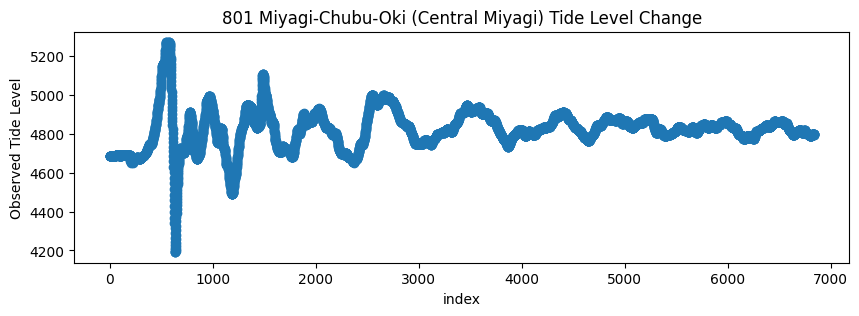

In [6]:
# 801Gの実測水位データの可視化
fig = plt.figure(figsize=(10,3))

cut_test_df = pd.read_csv(filename_path+"cut_2011TET801G.csv", index_col=0)
for i in range(len(cut_test_df)):
    s = cut_test_df.loc[i, "datetime"]
    cut_test_df.loc[i, "datetime"] = dt.strptime(s, "%Y-%m-%d %H:%M:%S")

plt.scatter(x=cut_test_df.index, y=cut_test_df["observed"])
plt.title("801 Miyagi-Chubu-Oki (Central Miyagi) Tide Level Change")
plt.xlabel("index")
plt.ylabel("Observed Tide Level")

fig.show()

#### 欠損値補完

In [7]:
# 欠損値補完
def completion(df:pd.DataFrame, nan_num, seed_val):
    random.seed(seed_val)
    nan_index = sorted(random.sample(range(1, len(df)-1), nan_num))

    nan_full_df = df.copy()
    for idx in nan_index:
        nan_full_df.loc[idx, "observed"] = float("nan")
    filled_df = nan_full_df.copy()

    for i in range(nan_num):
        if i != nan_num-1 and nan_index[i]+1 == nan_index[i+1]:
            filled_df.loc[nan_index[i], "observed"] = filled_df.loc[nan_index[i]-1, "observed"]
        else:
            filled_df.loc[nan_index[i], "observed"] = (filled_df.loc[nan_index[i]+1, "observed"]+
                                                    filled_df.loc[nan_index[i]-1, "observed"])/2

    return nan_full_df, filled_df, nan_index


# 補完したデータフレームを作成
def df_completion(pre_df: pd.DataFrame) -> pd.DataFrame:
    nan_index = []
    for i in range(len(pre_df)):
        if pre_df.loc[i].hasnans:
            nan_index.append(i)

    nan_full_df = pre_df.copy()
    for idx in nan_index:
        nan_full_df.loc[idx, "observed"] = float("nan")
    cmp_test_df = nan_full_df.copy()

    for i in range(len(nan_index)):
        if i == len(nan_index)-1 or nan_index[i]+1 == nan_index[i+1]:
            cmp_test_df.loc[nan_index[i], "observed"] = cmp_test_df.loc[nan_index[i]-1, "observed"]

        else:
            cmp_test_df.loc[nan_index[i], "observed"] = (cmp_test_df.loc[nan_index[i]+1, "observed"]+
                                                    cmp_test_df.loc[nan_index[i]-1, "observed"])/2

    # 合わせて潮位偏差も補完
    for i in range(len(cmp_test_df)):
        cmp_test_df.loc[i, "deviation"] = cmp_test_df.loc[i, "observed"] - cmp_test_df.loc[i, "astoro"]

    return cmp_test_df


In [8]:
# 801Gのデータのうち,欠損値を含む時刻の確認
nan_index = []
for i in range(len(cut_test_df)):
    if cut_test_df.loc[i].hasnans:
        nan_index.append(i)

cut_test_df["datetime"].iloc[nan_index]

205    2011-03-11 14:47:05
206    2011-03-11 14:47:10
207    2011-03-11 14:47:15
208    2011-03-11 14:47:20
209    2011-03-11 14:47:25
210    2011-03-11 14:47:30
211    2011-03-11 14:47:35
212    2011-03-11 14:47:40
213    2011-03-11 14:47:45
214    2011-03-11 14:47:50
215    2011-03-11 14:47:55
216    2011-03-11 14:48:00
217    2011-03-11 14:48:05
218    2011-03-11 14:48:10
219    2011-03-11 14:48:15
220    2011-03-11 14:48:20
221    2011-03-11 14:48:25
222    2011-03-11 14:48:30
223    2011-03-11 14:48:35
224    2011-03-11 14:48:40
225    2011-03-11 14:48:45
Name: datetime, dtype: object

In [9]:
# フルにデータを使える部分を抽出し、ランダムに発生させた欠損値に対して補完
start = cut_test_df[cut_test_df["datetime"] == dt(2011, 3, 11, 14, 48, 50)].index[0]

full_df = cut_test_df.iloc[start:].reset_index().drop("index", axis=1)
nan_test_df, completion_test_df, nan_index = completion(full_df, 3, seed_val=42)

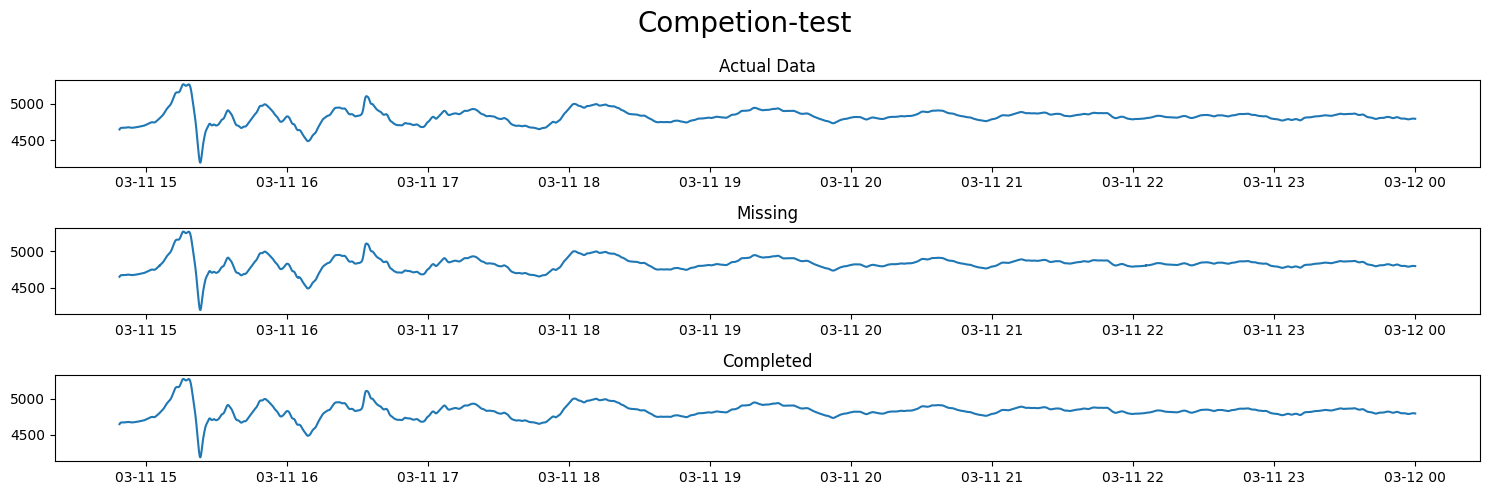

205     2011-03-11 15:05:55
913     2011-03-11 16:04:55
5239    2011-03-11 22:05:25
Name: datetime, dtype: object

In [10]:
# 補完前後のグラフを表示
fig, ax = plt.subplots(3,figsize=(15,5))

ax[0].plot(full_df["datetime"], full_df["observed"])
ax[0].set_title("Actual Data")

ax[1].plot(nan_test_df["datetime"], nan_test_df["observed"])
ax[1].set_title("Missing")

ax[2].plot(completion_test_df["datetime"], completion_test_df["observed"])
ax[2].set_title("Completed")

plt.suptitle("Competion-test", fontsize=20)
plt.tight_layout()
plt.show()

full_df.loc[nan_index, "datetime"]

In [11]:
# 補完方法の評価
num = 100
runs = 10**3

error = 0
for i in range(runs):
    nan_full_df, filled_df, nan_index = completion(full_df, num, seed_val=i)
    for idx in nan_index:
        error += abs(full_df.loc[idx, "observed"] - filled_df.loc[idx, "observed"])

# 平均絶対誤差に変換して出力
print(f"平均絶対誤差 :\n\terror : {error / (num * runs)}")

平均絶対誤差 :
	error : 0.12389290000000594


誤差はごく小さなものであるから,この方法を用いて,各データに対し補完を行う.

In [12]:
# 全水位データを補完データで置き換える
cmp_filename_path = "../data/tsunami/NOWPHAS_Tsunami_data/csv/cmp_csv/"

for file in df_list:
    df = pd.read_csv(filename_path+file, index_col=0)
    df = df_completion(df)
    df.to_csv(cmp_filename_path+file)

### データフレームの作成

In [13]:
# メインデータフレームの作成
main_df = cut_test_df
main_df = main_df.drop(["index", "deviation"], axis=1)

# 差分データと過去1分間の水位データを結合
main_df["observed_diff"] = None
for i in range(len(main_df)-1):   
    main_df.loc[i, "observed_diff"] = main_df.loc[i+1, "observed"] - main_df.loc[i, "observed"]

main_df_times = [f"observed_{5*i}s" for i in range(1, 13)]
for i in range(len(main_df_times)):
    main_df[main_df_times[i]] = main_df["observed"].shift(-i-1)

In [14]:
# 801Gより先に津波が到達した地点の,5秒前の水位データを結合
cmp_filenames = ["2011TET318T.csv", "2011TET317T.csv",
                 "2011TET315T.csv", "2011TET319T.csv",
                 "2011TET802G.csv", "2011TET804G.csv",
                 "2011TET803G.csv", "2011TET806G.csv"]

pre_list = []
pre_columns = []
for filename in cmp_filenames:
    pre_df = pd.read_csv(filename_path+file, index_col=0)
    pre_list.append(pre_df["observed"].shift(1))
    pre_columns.append(f"observed+{filename[7:11]}")

for i in range(len(pre_columns)):
    main_df[pre_columns[i]] = pre_list[i]

main_df

,observed,astoro,datetime,observed_diff,observed_5s,observed_10s,observed_15s,observed_20s,observed_25s,observed_30s,...,observed_55s,observed_60s,observed+318T,observed+317T,observed+315T,observed+319T,observed+802G,observed+804G,observed+803G,observed+806G
0,4687.00,4685.12,2011-03-11 14:30:00,0.0,4687.00,4686.90,4687.10,4686.90,4687.0,4687.0,...,4686.9,4686.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4687.00,4685.13,2011-03-11 14:30:05,-0.1,4686.90,4687.10,4686.90,4687.00,4687.0,4686.9,...,4686.7,4686.8,-56.27,-56.27,-56.27,-56.27,-56.27,-56.27,-56.27,-56.27
2,4686.90,4685.14,2011-03-11 14:30:10,0.2,4687.10,4686.90,4687.00,4687.00,4686.9,4687.0,...,4686.8,4686.7,-56.20,-56.20,-56.20,-56.20,-56.20,-56.20,-56.20,-56.20
3,4687.10,4685.16,2011-03-11 14:30:15,-0.2,4686.90,4687.00,4687.00,4686.90,4687.0,4686.8,...,4686.7,4686.7,-56.13,-56.13,-56.13,-56.13,-56.13,-56.13,-56.13,-56.13
4,4686.90,4685.17,2011-03-11 14:30:20,0.1,4687.00,4687.00,4686.90,4687.00,4686.8,4686.9,...,4686.7,4686.7,-56.05,-56.05,-56.05,-56.05,-56.05,-56.05,-56.05,-56.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,4797.95,4726.93,2011-03-11 23:59:35,-0.43,4797.52,4797.08,4796.47,4795.97,NaN,NaN,...,NaN,NaN,-11.62,-11.62,-11.62,-11.62,-11.62,-11.62,-11.62,-11.62
6836,4797.52,4726.93,2011-03-11 23:59:40,-0.44,4797.08,4796.47,4795.97,NaN,NaN,NaN,...,NaN,NaN,-11.55,-11.55,-11.55,-11.55,-11.55,-11.55,-11.55,-11.55
6837,4797.08,4726.93,2011-03-11 23:59:45,-0.61,4796.47,4795.97,NaN,NaN,NaN,NaN,...,NaN,NaN,-11.47,-11.47,-11.47,-11.47,-11.47,-11.47,-11.47,-11.47
6838,4796.47,4726.93,2011-03-11 23:59:50,-0.5,4795.97,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-11.38,-11.38,-11.38,-11.38,-11.38,-11.38,-11.38,-11.38


### 重回帰分析

In [15]:
# 重回帰分析を行う
def train_predict(X, y, split_rate):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_rate, random_state=316)
    regressor = LinearRegression().fit(X_train, y_train)
    
    y_train_pred = regressor.predict(X_train)
    y_pred = regressor.predict(X_test)
    for i in range(len(y_pred)):
        y_pred[i] = round(y_pred[i])
    
    train_mse = np.mean((y_train_pred - y_train) ** 2)
    test_mse = np.mean((y_pred - y_test) ** 2)
    print("MAE train data: ", train_mse)
    print("MSE test data: ", test_mse)

    out = {
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_train_pred": y_train_pred
    }

    return regressor, out

In [16]:
# 欠損値を含むものを削除
drop_list = ["observed_diff"]
drop_list += [f"observed_{5*i}s" for i in range(1, 13)]
drop_list += [f"observed+{filename[7:11]}" for filename in cmp_filenames]

main_df = main_df.dropna(subset=drop_list)

In [17]:
# 重回帰分析を実行
drop_list.remove("observed_diff")
X = main_df[drop_list+["astoro"]]
y = main_df["observed_diff"]
regressor, out = train_predict(X, y, 0.30)

MAE train data:  0.022113427580102284
MSE test data:  0.09915988229524621


In [18]:
print("r^2 train data: ", r2_score(out["y_train"], out["y_train_pred"]))
print("r^2 test data: ", r2_score(out["y_test"], out["y_pred"]))

r^2 train data:  0.9972659902990816
r^2 test data:  0.9859595034508374


テストデータを用いた場合の方が,誤差がより大きく,決定係数がより小さい.このことから,過学習が起きていると考えられる.

### 評価

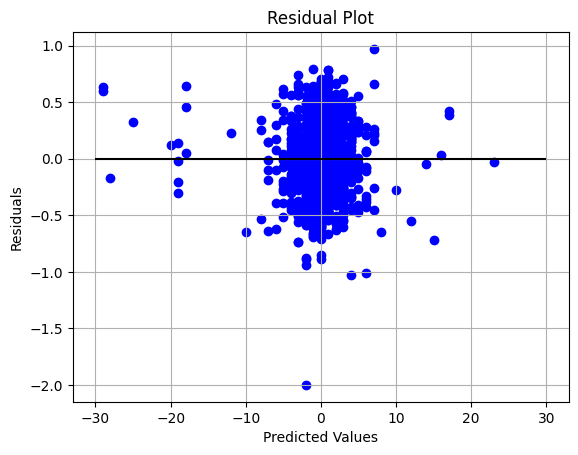

In [19]:
plt.scatter(out["y_pred"], out["y_pred"] - out["y_test"], color = "blue")
plt.hlines(y = 0, xmin = -30, xmax = 30, color="black")
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()

plt.show()

### メインデータの周期を調べる